Loading data...
Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Dropping simulated_price column from the dataset
Creating calculated features...
Using existing neighborhood encodings with 20 unique neighborhoods
Computing spatial features for all data...
Creating advanced spatial features...
Sampling 10000 records from 1123327 for reference data to save memory
Calculating distance features...
Building BallTree for spatial analysis...
Processing data in 1000-sized chunks with -1 parallel jobs...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Creating spatial features DataFrame...
Standardizing features...
Generated 17 spatial features
Cached spatial features saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\STRAP\CV_Model\cached_spatial_features.csv
Train data: 1123327 rows, 6291 unique listings
Test data: 281142 rows, 1573 unique listings
Creating temporal sequences from historical data...
Creating temporal sequences with window_size=5...
Processing sequences for 6291 unique listings
Using 67 features for sequences (including spatial features)
Created 1091872 sequences from 6291 listings
Sequence shape: (5, 67)
Created temporal datasets - Train: 873497, Val: 218375
Sequence feature dimension: 67
Using device: cuda
Getting exact feature dimensions from sequences...
Sequence feature dimension from data: 67
No sequences available, using regular feature dimension: 67
Using MLP for spatial modeling instead of graph convolution
Model initialized with stable configuration

===== Training with Standard Features =====
Trai

c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Evaluating with standard feature batch: torch.Size([512, 67])
Epoch 1/30 - 40.1s - Train Loss: 0.2174, Val Loss: 0.2051, RMSE: 0.6944, R²: 0.5191, LR: 0.000300
Validation loss improved from inf to 0.2051
Detected standard feature batch with shape: torch.Size([512, 67])
Evaluating with standard feature batch: torch.Size([512, 67])
Epoch 2/30 - 38.9s - Train Loss: 0.1978, Val Loss: 0.1876, RMSE: 0.6590, R²: 0.5669, LR: 0.000300
Validation loss improved from 0.2051 to 0.1876
Detected standard feature batch with shape: torch.Size([512, 67])
Evaluating with standard feature batch: torch.Size([512, 67])
Epoch 3/30 - 37.2s - Train Loss: 0.1871, Val Loss: 0.1826, RMSE: 0.6437, R²: 0.5868, LR: 0.000300
Validation loss improved from 0.1876 to 0.1826
Detected standard feature batch with shape: torch.Size([512, 67])
Evaluating with standard feature batch: torch.Size([512, 67])
Epoch 4/30 - 34.5s - Train Loss: 0.1802, Val Loss: 0.1726, RMSE: 0.6233, R²: 0.6125, LR: 0.000300
Validation loss improved

c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Evaluating with temporal sequence batch: torch.Size([512, 5, 67])
Epoch 1/20 - 81.9s - Train Loss: 0.2257, Val Loss: 0.2069, RMSE: 0.6992, R²: 0.5068, LR: 0.000100
Validation loss improved from inf to 0.2069
Detected temporal sequence batch with shape: torch.Size([512, 5, 67])
Evaluating with temporal sequence batch: torch.Size([512, 5, 67])
Epoch 2/20 - 80.7s - Train Loss: 0.2077, Val Loss: 0.1963, RMSE: 0.6746, R²: 0.5407, LR: 0.000100
Validation loss improved from 0.2069 to 0.1963
Detected temporal sequence batch with shape: torch.Size([512, 5, 67])
Evaluating with temporal sequence batch: torch.Size([512, 5, 67])
Epoch 3/20 - 78.0s - Train Loss: 0.1984, Val Loss: 0.1900, RMSE: 0.6624, R²: 0.5573, LR: 0.000100
Validation loss improved from 0.1963 to 0.1900
Detected temporal sequence batch with shape: torch.Size([512, 5, 67])
Evaluating with temporal sequence batch: torch.Size([512, 5, 67])
Epoch 4/20 - 79.6s - Train Loss: 0.1913, Val Loss: 0.1824, RMSE: 0.6393, R²: 0.5876, LR: 0.000

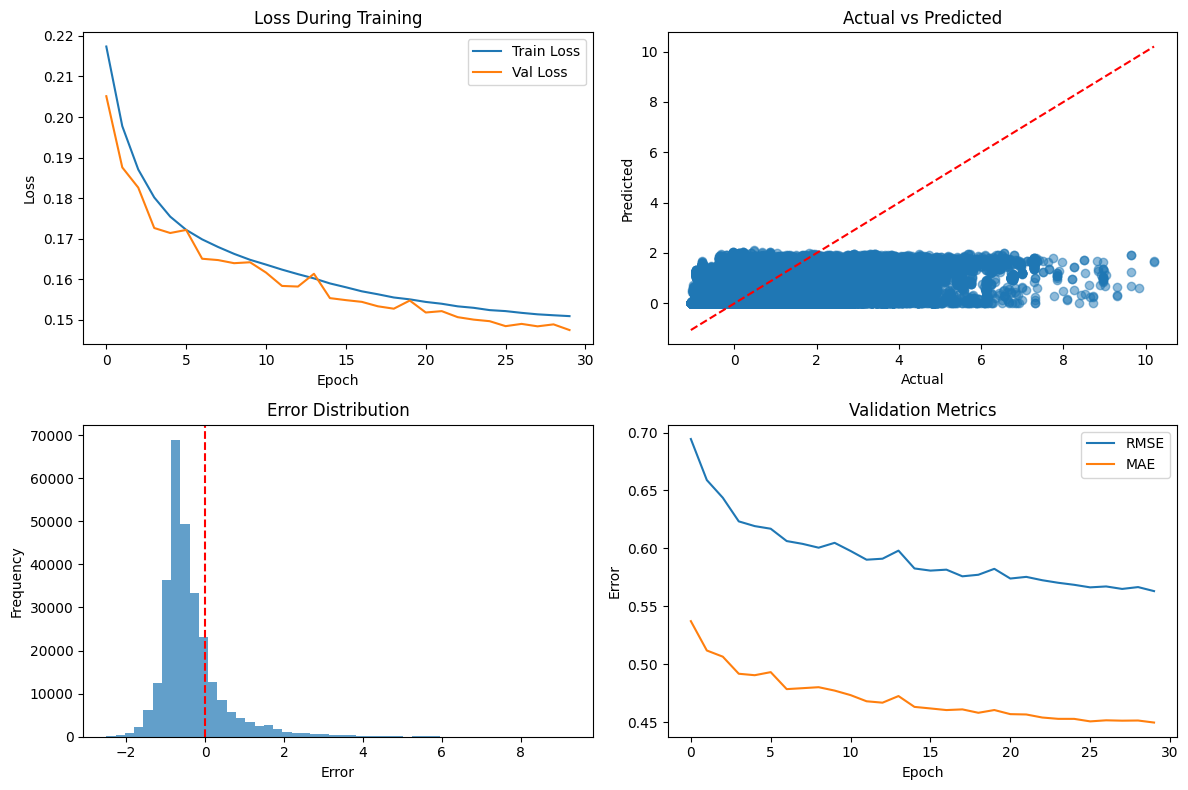

Model training completed successfully!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import radians
import warnings
from datetime import datetime

# 1. Utility functions and dataset classes
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

class TemporalSequenceDataset(Dataset):
    """Dataset for temporal sequence data"""
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Convert to tensor with shape [sequence_length, features]
        sequence = torch.FloatTensor(self.sequences[idx])
        target = torch.FloatTensor([self.targets[idx]])
        
        return sequence, target.squeeze(0)

# 2. Feature creation functions
def create_calculated_features(df):
    """
    Create calculated features from existing data
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe to add features to
    
    Returns:
    --------
    DataFrame
        Modified dataframe with new features
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Bedroom ratio
    if 'bedrooms' in df_copy.columns and 'accommodates' in df_copy.columns:
        df_copy['bedroom_ratio'] = df_copy['bedrooms'] / df_copy['accommodates'].clip(lower=1)
    
    # Count amenities
    amenity_columns = df_copy.filter(like='has_').columns
    if len(amenity_columns) > 0:
        df_copy['amenity_count'] = df_copy[amenity_columns].sum(axis=1)
    
    # Luxury score
    luxury_amenities = ['has_hot_water', 'has_hair_dryer', 'has_dedicated_workspace']
    has_all_columns = all(col in df_copy.columns for col in luxury_amenities)
    
    if has_all_columns:
        df_copy['luxury_score'] = df_copy[luxury_amenities].sum(axis=1) / len(luxury_amenities)
    else:
        # If some columns are missing, use available ones or set to 0
        available_amenities = [col for col in luxury_amenities if col in df_copy.columns]
        if available_amenities:
            df_copy['luxury_score'] = df_copy[available_amenities].sum(axis=1) / len(available_amenities)
        else:
            df_copy['luxury_score'] = 0
    
    
    # Seasonality features
    if 'date' in df_copy.columns:
        try:
            if not pd.api.types.is_datetime64_any_dtype(df_copy['date']):
                df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')
            
            df_copy['month'] = df_copy['date'].dt.month
            df_copy['day_of_week'] = df_copy['date'].dt.dayofweek
            df_copy['is_weekend'] = df_copy['day_of_week'].isin([5, 6]).astype(int)
            df_copy['is_holiday_season'] = ((df_copy['month'] == 12) | (df_copy['month'] == 1)).astype(int)
        except Exception as e:
            print(f"Error creating date features: {str(e)}")
            
    # Fill any NaN values that might have been created
    numeric_cols = df_copy.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    
    return df_copy

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1, train_data_only=None):
    """Advanced memory-optimized spatial features for real estate predictions
    
    Parameters:
    -----------
    df : DataFrame
        The data to create features for
    k_neighbors : int
        Number of neighbors to use for KNN features
    chunk_size : int
        Size of chunks for parallel processing
    n_jobs : int
        Number of parallel jobs (-1 uses all available cores)
    train_data_only : DataFrame, optional
        If provided, use only this data for computing the KNN features
        This prevents data leakage by ensuring test listings don't influence each other
    """
    import numpy as np
    import pandas as pd
    import math
    import warnings
    from sklearn.neighbors import BallTree
    from joblib import Parallel, delayed
    
    print("Creating advanced spatial features...")
    
    # Use a smaller sample if dataset is very large
    reference_data = train_data_only if train_data_only is not None else df
    
    # If dataset is very large, sample it for reference data
    MAX_REFERENCE_SIZE = 10000  # Limit reference data size
    if len(reference_data) > MAX_REFERENCE_SIZE:
        print(f"Sampling {MAX_REFERENCE_SIZE} records from {len(reference_data)} for reference data to save memory")
        np.random.seed(42)
        reference_indices = np.random.choice(len(reference_data), MAX_REFERENCE_SIZE, replace=False)
        reference_data = reference_data.iloc[reference_indices].copy()
    
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(reference_data) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    # Paris city center (for distance calculations) - adjust for your location if needed
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Initialize spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'east_west': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'knn_price_median': [],
        'knn_price_range': [],
        'knn_price_min': [],
        'knn_price_max': [],
        'price_quantile_25': [],
        'price_quantile_75': [],
        'distance_weighted_price': [],
        'inverse_distance_weighted_price': [],
        'gaussian_weighted_price': [],
        'location_score': []
    }
    
    # Calculate basic distance features
    print("Calculating distance features...")
    
    def calculate_distance(lat1, lon1, lat2, lon2):
        """Calculate the Haversine distance between two points"""
        R = 6371  # Radius of the Earth in kilometers
        
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        distance = R * c
        return distance
    
    if 'latitude' in df.columns and 'longitude' in df.columns:
        spatial_data['distance_to_center'] = df.apply(
            lambda row: calculate_distance(
                row['latitude'], 
                row['longitude'], 
                city_center_lat, 
                city_center_lon
            ),
            axis=1
        ).values
        
        spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
        spatial_data['east_west'] = (df['longitude'] - city_center_lon).values
    else:
        # If no lat/long, create random distances
        print("No latitude/longitude columns found. Using random values.")
        np.random.seed(42)
        spatial_data['distance_to_center'] = np.random.uniform(0, 10, size=len(df))
        spatial_data['north_south'] = np.random.uniform(-5, 5, size=len(df))
        spatial_data['east_west'] = np.random.uniform(-5, 5, size=len(df))
    
    # Create a location score (inverse of distance to center with quadratic decay)
    spatial_data['location_score'] = 1 / (spatial_data['distance_to_center']**2 + 0.1)
    
    # Enhanced BallTree processing
    print("Building BallTree for spatial analysis...")
    if 'latitude' in df.columns and 'longitude' in df.columns:
        # Use only training data for the reference tree to prevent data leakage
        all_coords = np.radians(reference_data[['latitude', 'longitude']].values)
        tree = BallTree(all_coords, metric='haversine')
        
        if 'price' in reference_data.columns:
            all_prices = reference_data['price'].values
        else:
            print("No price column found. Using random values for price-based features.")
            np.random.seed(42)
            all_prices = np.random.uniform(100, 1000, size=len(reference_data))
        
        def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
            """Enhanced chunk processing with additional metrics"""
            coords = np.radians(chunk_data[['latitude', 'longitude']].values)
            # Use adaptive k value
            k_query = min(k_neighbors + 1, len(all_coords))
            distances, indices = tree.query(coords, k=k_query)
            
            # Convert distances from radians to kilometers
            distances_km = distances * 6371  # Earth radius in km
            
            # Handle special cases with small datasets
            if k_query == 1:
                # Just return zeros or appropriate values for a single point
                n_samples = len(chunk_data)
                return {
                    'knn_price_mean': np.zeros(n_samples),
                    'knn_price_std': np.zeros(n_samples),
                    'knn_price_median': np.zeros(n_samples),
                    'knn_price_range': np.zeros(n_samples),
                    'knn_price_min': np.zeros(n_samples),
                    'knn_price_max': np.zeros(n_samples),
                    'price_quantile_25': np.zeros(n_samples),
                    'price_quantile_75': np.zeros(n_samples),
                    'distance_weighted_price': np.zeros(n_samples),
                    'inverse_distance_weighted_price': np.zeros(n_samples),
                    'gaussian_weighted_price': np.zeros(n_samples)
                }
            
            # Process neighbor data if we have multiple points
            neighbor_prices = np.take(all_prices, indices[:, 1:])
    
            
            # Calculate different weights
            # 1. Linear distance weighting
            linear_weights = 1 / (distances_km[:, 1:] + 1e-6)
            linear_weights = linear_weights / linear_weights.sum(axis=1, keepdims=True)
            
            # 2. Inverse distance weighting (quadratic)
            inverse_weights = 1 / (distances_km[:, 1:]**2 + 1e-6)
            inverse_weights = inverse_weights / inverse_weights.sum(axis=1, keepdims=True)
            
            # 3. Gaussian distance weighting
            sigma = 1.0  # bandwidth parameter
            gaussian_weights = np.exp(-distances_km[:, 1:]**2 / (2 * sigma**2))
            gaussian_weights = gaussian_weights / gaussian_weights.sum(axis=1, keepdims=True)
            
            # Calculate neighbor statistics
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
                
                # Basic statistics
                mean_prices = np.nanmean(neighbor_prices, axis=1)
                std_prices = np.nanstd(neighbor_prices, axis=1)
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                min_prices = np.nanmin(neighbor_prices, axis=1)
                max_prices = np.nanmax(neighbor_prices, axis=1)
                range_prices = max_prices - min_prices
                
                # Quantiles
                q25_prices = np.nanpercentile(neighbor_prices, 25, axis=1)
                q75_prices = np.nanpercentile(neighbor_prices, 75, axis=1)
                
                # Weighted prices
                linear_weighted_prices = np.sum(linear_weights * neighbor_prices, axis=1)
                inverse_weighted_prices = np.sum(inverse_weights * neighbor_prices, axis=1)
                gaussian_weighted_prices = np.sum(gaussian_weights * neighbor_prices, axis=1)
            
            return {
                'knn_price_mean': mean_prices,
                'knn_price_std': std_prices,
                'knn_price_median': median_prices,
                'knn_price_range': range_prices,
                'knn_price_min': min_prices,
                'knn_price_max': max_prices,
                'price_quantile_25': q25_prices,
                'price_quantile_75': q75_prices,
                'distance_weighted_price': linear_weighted_prices,
                'inverse_distance_weighted_price': inverse_weighted_prices,
                'gaussian_weighted_price': gaussian_weighted_prices
            }
        
        # Split and process chunks
        print(f"Processing data in {chunk_size}-sized chunks with {n_jobs} parallel jobs...")
        n_chunks = math.ceil(len(df) / chunk_size)
        chunks = np.array_split(df, n_chunks)
        
        results = Parallel(n_jobs=n_jobs)(
            delayed(enhanced_process_chunk)(
                chunk, 
                tree, 
                actual_k,  # Use adjusted k value
                all_prices
            ) for chunk in chunks
        )
        
        # Combine results
        for key in spatial_data.keys():
            if key not in ['distance_to_center', 'north_south', 'east_west', 'location_score']:
                spatial_data[key] = np.concatenate([r[key] for r in results])
    else:
        # If no spatial data, create random values for remaining features
        print("No spatial data available. Using random values for all KNN features.")
        n_samples = len(df)
        np.random.seed(42)
        for key in spatial_data.keys():
            if key not in ['distance_to_center', 'north_south', 'east_west', 'location_score']:
                spatial_data[key] = np.random.normal(0, 1, size=n_samples)
    
    # Convert to DataFrame
    print("Creating spatial features DataFrame...")
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Add polar coordinates
    spatial_features['radial_distance'] = np.sqrt(spatial_features['north_south']**2 + spatial_features['east_west']**2)
    spatial_features['angular_position'] = np.arctan2(spatial_features['north_south'], spatial_features['east_west'])
    
    # Standardize features
    print("Standardizing features...")
    features_to_standardize = spatial_features.columns
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    print(f"Generated {len(spatial_features.columns)} spatial features")
    return spatial_features

def create_temporal_sequences(df, spatial_features, window_size=5):
    print(f"Creating temporal sequences with window_size={window_size}...")
    
    # Make sure the DataFrame is sorted by date for each listing
    df = df.sort_values(['listing_id', 'date'])
    
    # Get unique listing IDs
    unique_listings = df['listing_id'].unique()
    total_listings = len(unique_listings)
    print(f"Processing sequences for {total_listings} unique listings")
    
    # Initialize result containers
    all_sequences = []
    all_targets = []
    all_listing_ids = []
    
    # IMPORTANT: Get the feature columns once to ensure consistency
    exclude_cols = ['listing_id', 'date', 'price', 'neighborhood_id']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # CRUCIAL FIX: Add spatial features to ensure dimensional consistency
    df_with_spatial = pd.concat([df, spatial_features.loc[df.index]], axis=1)
    combined_feature_cols = list(set(feature_cols) | set(spatial_features.columns))
    
    print(f"Using {len(combined_feature_cols)} features for sequences (including spatial features)")
    
    # Process each listing
    for listing_id in unique_listings:
        # Get data for this listing
        listing_data = df_with_spatial[df_with_spatial['listing_id'] == listing_id].sort_values('date')
        
        # Skip if we don't have enough data points
        if len(listing_data) < window_size + 1:
            continue
        
        # Create sequences
        for i in range(len(listing_data) - window_size):
            # Input sequence with combined features
            seq_df = listing_data.iloc[i:i+window_size]
            features = seq_df[combined_feature_cols].values
            
            # Target (next price)
            target = listing_data.iloc[i+window_size]['price']
            
            all_sequences.append(features)
            all_targets.append(target)
            all_listing_ids.append(listing_id)
    
    print(f"Created {len(all_sequences)} sequences from {total_listings} listings")
    if all_sequences:
        print(f"Sequence shape: {all_sequences[0].shape}")
    
    # Convert lists to numpy arrays
    result = {
        'sequences': np.array(all_sequences) if all_sequences else np.array([]),
        'targets': np.array(all_targets) if all_targets else np.array([]),
        'listing_ids': np.array(all_listing_ids) if all_listing_ids else np.array([])
    }
    
    return result

# 3. Model training and evaluation functions
def train_improved_strap_epoch(model, train_loader, optimizer, criterion, device, clip_value=1.0):
    """Train improved STRAP model for one epoch with robust NaN handling"""
    model.train()
    epoch_loss = 0
    batch_count = 0
    nan_count = 0
    
    # Check batch structure from the first batch to determine data type
    for sample_batch in train_loader:
        # For temporal sequences, the first element would be a 3D tensor [batch_size, seq_len, features]
        if isinstance(sample_batch[0], torch.Tensor) and len(sample_batch[0].shape) == 3:
            print(f"Detected temporal sequence batch with shape: {sample_batch[0].shape}")
            is_temporal_mode = True
        else:
            print(f"Detected standard feature batch with shape: {sample_batch[0].shape}")
            is_temporal_mode = False
        break
    
    for batch in train_loader:
        try:
            if is_temporal_mode:
                # This is a sequence batch
                sequences, targets = batch
                sequences = sequences.to(device)
                targets = targets.to(device)
                if targets.dim() > 1:
                    targets = targets.squeeze(-1)
                
                # Forward pass with sequences
                outputs = model(x=None, time_sequences=sequences)
            else:
                # Regular batch
                batch_x, batch_y = batch
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                # Forward pass without sequences
                outputs = model(x=batch_x, time_sequences=None)
                targets = batch_y
            
            # Check for NaN in outputs
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs, replacing with zeros")
                outputs = torch.where(torch.isnan(outputs), torch.zeros_like(outputs), outputs)
                nan_count += 1
                if nan_count > 5:  # Too many NaNs, reduce learning rate
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.5
                    print(f"Reducing learning rate to {optimizer.param_groups[0]['lr']}")
                    nan_count = 0
            
            # Calculate loss with stability check
            loss = criterion(outputs, targets)
            
            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print("NaN or Inf detected in loss, skipping batch")
                continue
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            # Check for NaN in gradients
            has_nan_grad = False
            for param in model.parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    has_nan_grad = True
                    break
            
            if has_nan_grad:
                print("NaN or Inf detected in gradients, skipping update")
                continue
            
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
            
        except RuntimeError as e:
            print(f"Runtime error during batch: {str(e)}")
            continue
    
    return epoch_loss / max(1, batch_count)

def evaluate_strap(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    batch_count = 0
    
    # Detect batch type first
    for sample_batch in data_loader:
        if isinstance(sample_batch[0], torch.Tensor) and len(sample_batch[0].shape) == 3:
            print(f"Evaluating with temporal sequence batch: {sample_batch[0].shape}")
            is_temporal_mode = True
        else:
            print(f"Evaluating with standard feature batch: {sample_batch[0].shape}")
            is_temporal_mode = False
        break
    
    with torch.no_grad():
        for batch in data_loader:
            try:
                if is_temporal_mode:
                    # Sequence batch
                    sequences, targets = batch
                    sequences = sequences.to(device)
                    targets = targets.to(device)
                    if targets.dim() > 1:
                        targets = targets.squeeze(-1)
                    
                    # Forward pass with sequences
                    outputs = model(x=None, time_sequences=sequences)
                else:
                    # Regular batch
                    batch_x, batch_y = batch
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    
                    # Forward pass
                    outputs = model(x=batch_x, time_sequences=None)
                    targets = batch_y
                
                # Handle NaN outputs
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    outputs = torch.where(torch.isnan(outputs) | torch.isinf(outputs), 
                                         torch.zeros_like(outputs), outputs)
                
                # Calculate loss
                loss = criterion(outputs, targets)
                if not torch.isnan(loss).any() and not torch.isinf(loss).any():
                    total_loss += loss.item()
                    batch_count += 1
                
                # Store predictions and targets for metrics
                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
                
            except RuntimeError as e:
                print(f"Runtime error during evaluation: {str(e)}")
                continue
    
    # Concatenate all predictions and targets
    try:
        all_predictions = np.concatenate(all_predictions)
        all_targets = np.concatenate(all_targets)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        mae = mean_absolute_error(all_targets, all_predictions)
        r2 = r2_score(all_targets, all_predictions) if len(set(all_targets)) > 1 else np.nan
        
        avg_loss = total_loss / max(1, batch_count)
        
        metrics = {
            'loss': avg_loss,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        
        return all_predictions, all_targets, metrics
        
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return None, None, {'loss': float('inf'), 'rmse': float('inf'), 'mae': float('inf'), 'r2': float('nan')}

def train_model(model, train_loader, val_loader, num_epochs=50, patience=7, 
                learning_rate=0.001, weight_decay=1e-5, device='cuda'):
    """
    Train the ImprovedSTRAP model with robust error handling and early stopping
    
    Parameters:
    -----------
    model : ImprovedSTRAP
        The model to train
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    num_epochs : int
        Maximum number of epochs to train
    patience : int
        Number of epochs to wait before early stopping
    learning_rate : float
        Initial learning rate
    weight_decay : float
        L2 regularization strength
    device : str
        Device to train on ('cuda' or 'cpu')
        
    Returns:
    --------
    model : ImprovedSTRAP
        Trained model
    history : dict
        Training history
    """
    import time
    start_time = time.time()
    
    for batch in train_loader:
        is_temporal = isinstance(batch[0], tuple) and len(batch[0]) == 2
        if is_temporal:
            print(f"Training in temporal sequence mode")
            seq, _ = batch[0]
            print(f"Sequence shape: {seq.shape}")
            print(f"Model's sequence_embedding input features: {model.sequence_embedding.in_features}")
        else:
            print(f"Training in standard feature mode")
            x, _ = batch
            print(f"Feature shape: {x.shape[1]}")
            print(f"Model's property_embedding input features: {model.property_embedding.in_features}")
        break

    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    min_delta = 0.001
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'val_r2': [],
        'learning_rates': []
    }
    
    print(f"Starting training on {device}...")
    
    try:
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Train for one epoch
            train_loss = train_improved_strap_epoch(
                model=model,
                train_loader=train_loader,
                optimizer=optimizer,
                criterion=criterion,
                device=device,
                clip_value=0.5  # More aggressive gradient clipping
            )
            
            # Evaluate on validation set
            _, _, val_metrics = evaluate_strap(
                model=model,
                data_loader=val_loader,
                criterion=criterion,
                device=device
            )
            
            val_loss = val_metrics['loss']
            
            # Update learning rate scheduler
            scheduler.step(val_loss)
            
            # Store current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_rmse'].append(val_metrics['rmse'])
            history['val_mae'].append(val_metrics['mae'])
            history['val_r2'].append(val_metrics['r2'])
            history['learning_rates'].append(current_lr)
            
            # Print progress
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"RMSE: {val_metrics['rmse']:.4f}, R²: {val_metrics['r2']:.4f}, "
                  f"LR: {current_lr:.6f}")
            
            # Check for improvement
            if val_loss < best_val_loss - min_delta:
                print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
                print(f"No improvement in validation loss. Counter: {counter}/{patience}")
            
            # Early stopping
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            # Check if learning rate is too small
            if current_lr < 1e-7:
                print(f"Learning rate ({current_lr}) too small, stopping training")
                break
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.1f} seconds")
        
        # Load best model if we found one
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print("Loaded best model state")
        
        return model, history
    
    except Exception as e:
        print(f"Training error: {str(e)}")
        
        # If we have a saved best model, load it
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print("Loaded best model state despite error")
        
        return model, history

# 4. ImprovedSTRAP model definition
class ImprovedSTRAP(nn.Module):
    """Improved Spatio-Temporal Real Estate Appraisal (STRAP) model with advanced sequence processing"""
    def __init__(self, input_dim, hidden_dim=128, num_gru_layers=2, dropout=0.1, num_neighborhoods=100, seq_feature_dim=None):
        super(ImprovedSTRAP, self).__init__()
        
        # Set sequence feature dimension - this is the dimension of features in the temporal sequences
        self.seq_feature_dim = seq_feature_dim if seq_feature_dim is not None else input_dim
        
        # Add a sequence embedding layer to project sequence features to hidden dimension
        self.sequence_embedding = nn.Linear(self.seq_feature_dim, hidden_dim)
        
        # Property feature embedding
        self.property_embedding = nn.Linear(input_dim, hidden_dim)
        
        # Embedding layer for categorical features like neighborhood
        self.neighborhood_embedding = nn.Embedding(num_neighborhoods, 32)
        
        # Temporal GRU layers
        self.gru = nn.GRU(
            input_size=hidden_dim,  # Now using hidden_dim as input size after embedding
            hidden_size=hidden_dim,
            num_layers=num_gru_layers,
            batch_first=True,
            dropout=dropout if num_gru_layers > 1 else 0
        )
        
        # 1D convolutional layer for local feature extraction
        self.conv1d = nn.Conv1d(
            in_channels=hidden_dim, 
            out_channels=hidden_dim, 
            kernel_size=3, 
            padding=1
        )
        
        # Transformer encoder for better sequence modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=4,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2
        )
        
        # Spatial graph layers - using a simple alternative since we might not have torch_geometric
        print("Using MLP for spatial modeling instead of graph convolution")
        self.graph_conv = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim)
        )
        self.use_geometric = False
        
        # Normalization
        self.temporal_norm = nn.LayerNorm(hidden_dim)
        self.spatial_norm = nn.LayerNorm(hidden_dim)
        self.conv_norm = nn.LayerNorm(hidden_dim)
        self.transformer_norm = nn.LayerNorm(hidden_dim)
        
        # Batch normalization layers
        self.gru_bn = nn.BatchNorm1d(hidden_dim)
        self.conv_bn = nn.BatchNorm1d(hidden_dim)
        self.transformer_bn = nn.BatchNorm1d(hidden_dim)
        self.final_bn = nn.BatchNorm1d(hidden_dim * 2)
        
        # Attention mechanism - modified for stability
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
            # Softmax will be applied manually with more stability checks
        )
        
        # Final prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        # Control flag for residual connections
        self.residual_connection = True
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize model weights for stable training"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.1)
    
    def _check_nan(self, tensor, name):
        """Check if tensor contains NaN values and handle them"""
        if tensor is None:
            return None
            
        if torch.isnan(tensor).any():
            print(f"NaN detected in {name}")
            # Replace NaN values with zeros
            fixed_tensor = torch.where(torch.isnan(tensor), torch.zeros_like(tensor), tensor)
            return fixed_tensor
        return tensor
    
    def _safe_softmax(self, tensor, dim=-1):
        """Apply softmax in a numerically stable way to avoid NaN values"""
        # Subtract max for numerical stability before applying softmax
        tensor = tensor - tensor.max(dim=dim, keepdim=True)[0].detach()
        exp_tensor = torch.exp(tensor)
        # Add small epsilon to avoid division by zero
        summed = exp_tensor.sum(dim=dim, keepdim=True) + 1e-10
        return exp_tensor / summed
        
    def forward(self, x=None, edge_index=None, time_sequences=None, neighborhood_ids=None):
        """
        Forward pass for ImprovedSTRAP model with comprehensive NaN handling
        
        Parameters:
        -----------
        x : Tensor, optional
            Regular property features
        edge_index : Tensor, optional
            Graph edge index for spatial connections
        time_sequences : Tensor, optional
            Temporal sequences for each property
        neighborhood_ids : Tensor, optional
            Neighborhood category IDs
            
        Returns:
        --------
        Tensor
            Predicted property prices
        """
        # Case 1: Only time_sequences is provided (sequence-only mode)
        if x is None and time_sequences is not None:
            # Apply NaN checking to input
            time_sequences = self._check_nan(time_sequences, "time_sequences input")
            
            batch_size, seq_len, seq_features = time_sequences.size()
            
            # Check for dimension mismatch and fix it
            if seq_features != self.seq_feature_dim:
                print(f"WARNING: Sequence feature dimension mismatch. Expected {self.seq_feature_dim}, got {seq_features}")
                
                if seq_features < self.seq_feature_dim:
                    # Pad with zeros if needed
                    padding = torch.zeros(batch_size, seq_len, self.seq_feature_dim - seq_features, device=time_sequences.device)
                    time_sequences = torch.cat([time_sequences, padding], dim=2)
                    print(f"Padded sequences to dimension {time_sequences.size(2)}")
                else:
                    # Truncate if too large
                    time_sequences = time_sequences[:, :, :self.seq_feature_dim]
                    print(f"Truncated sequences to dimension {time_sequences.size(2)}")
            
            # Use the actual shape for reshaping, not self.seq_feature_dim
            seq_feature_dim_actual = time_sequences.size(2)
            time_sequences_flat = time_sequences.reshape(-1, seq_feature_dim_actual)
            
            # Add dimension check for safety
            if seq_feature_dim_actual != self.sequence_embedding.in_features:
                print(f"CRITICAL: Input dimension mismatch for sequence_embedding. Got {seq_feature_dim_actual}, expected {self.sequence_embedding.in_features}")
                # Create a temporary adapter layer if needed
                temp_layer = nn.Linear(seq_feature_dim_actual, self.sequence_embedding.in_features).to(time_sequences.device)
                nn.init.xavier_uniform_(temp_layer.weight)
                nn.init.zeros_(temp_layer.bias)
                time_sequences_flat = temp_layer(time_sequences_flat)
                    
            time_sequences_emb = self.sequence_embedding(time_sequences_flat)
            time_sequences_emb = self._check_nan(time_sequences_emb, "sequence_embedding output")
            time_sequences_emb = time_sequences_emb.reshape(batch_size, seq_len, -1)
            
            # Process with GRU using the embedded sequences
            gru_output, _ = self.gru(time_sequences_emb)
            gru_output = self._check_nan(gru_output, "gru output")
            
            # Apply batch norm to GRU output
            if gru_output.size(0) > 1:
                gru_output_bn = gru_output.transpose(1, 2)
                gru_output_bn = self.gru_bn(gru_output_bn)
                gru_output = gru_output_bn.transpose(1, 2)
            gru_output = self._check_nan(gru_output, "gru_bn output")
            
            # Apply 1D convolution for local feature extraction
            conv_input = gru_output.transpose(1, 2)
            conv_output = self.conv1d(conv_input)
            
            # Apply batch norm to Conv output
            if conv_output.size(0) > 1:
                conv_output = self.conv_bn(conv_output)
            conv_output = self._check_nan(conv_output, "conv_bn output")
            conv_output = conv_output.transpose(1, 2)
            
            # Apply residual connection
            if self.residual_connection:
                conv_output = conv_output + gru_output
                conv_output = self._check_nan(conv_output, "residual connection 1")
            
            # Apply transformer encoder for global context
            try:
                transformer_output = self.transformer_encoder(conv_output)
                transformer_output = self._check_nan(transformer_output, "transformer output")
            except RuntimeError as e:
                print(f"Transformer error: {str(e)}. Using conv_output instead.")
                transformer_output = conv_output
            
            # Apply batch norm to transformer output
            if transformer_output.size(0) > 1:
                transformer_output_bn = transformer_output.transpose(1, 2)
                transformer_output_bn = self.transformer_bn(transformer_output_bn)
                transformer_output = transformer_output_bn.transpose(1, 2)
            transformer_output = self._check_nan(transformer_output, "transformer_bn output")
            
            # Apply residual connection
            if self.residual_connection:
                transformer_output = transformer_output + conv_output
                transformer_output = self._check_nan(transformer_output, "residual connection 2")
            
            # Apply attention
            attention_scores = self.attention(transformer_output)
            attention_scores = self._check_nan(attention_scores, "attention scores")
            attention_weights = self._safe_softmax(attention_scores, dim=1)
            attention_weights = self._check_nan(attention_weights, "attention weights")
            
            context_vector = torch.sum(attention_weights * transformer_output, dim=1)
            context_vector = self._check_nan(context_vector, "context vector")
            temporal_output = self.temporal_norm(context_vector)
            temporal_output = self._check_nan(temporal_output, "temporal output")
            
            # Since we don't have property features, use the temporal output for both parts
            spatial_output = temporal_output.clone()
            
            # Combine temporal and spatial outputs
            combined = torch.cat([temporal_output, spatial_output], dim=1)
            combined = self._check_nan(combined, "combined output")
            
            # Apply batch norm to combined features
            if combined.size(0) > 1:
                combined = self.final_bn(combined)
            combined = self._check_nan(combined, "final_bn output")
            
            # Final prediction
            output = self.predictor(combined).squeeze(-1)
            
            # Check for NaN values in final output
            output = self._check_nan(output, "model output")
            
            # Safeguard against extreme values
            output = torch.clamp(output, min=0.0, max=10000.0)
            
            return output
            
        # Case 2: x is provided (with or without time_sequences)
        elif x is not None:
            # Apply NaN checking to input
            x = self._check_nan(x, "property features input")
            batch_size = x.size(0)
            
            # Process property features
            property_emb = self.property_embedding(x)
            property_emb = self._check_nan(property_emb, "property embedding")
            
            # Process neighborhood embeddings if provided
            if neighborhood_ids is not None:
                neighborhood_emb = self.neighborhood_embedding(neighborhood_ids)
                neighborhood_emb = self._check_nan(neighborhood_emb, "neighborhood embedding")
                # Combine with property embedding
                property_emb = property_emb + neighborhood_emb
                property_emb = self._check_nan(property_emb, "combined embedding")
            
            # Process temporal information using sequences if provided
            if time_sequences is not None:
                # Check and fix sequence dimensions if necessary
                time_sequences = self._check_nan(time_sequences, "time_sequences input")
                batch_size, seq_len, seq_features = time_sequences.size()
                
                if seq_features != self.seq_feature_dim:
                    print(f"WARNING: Sequence feature dimension mismatch. Expected {self.seq_feature_dim}, got {seq_features}")
                    
                    if seq_features < self.seq_feature_dim:
                        # Pad with zeros if needed
                        padding = torch.zeros(batch_size, seq_len, self.seq_feature_dim - seq_features, device=time_sequences.device)
                        time_sequences = torch.cat([time_sequences, padding], dim=2)
                        print(f"Padded sequences to dimension {time_sequences.size(2)}")
                    else:
                        # Truncate if too large
                        time_sequences = time_sequences[:, :, :self.seq_feature_dim]
                        print(f"Truncated sequences to dimension {time_sequences.size(2)}")
                
                # Project sequence features to hidden dimension
                time_sequences_flat = time_sequences.reshape(-1, self.seq_feature_dim)
                time_sequences_emb = self.sequence_embedding(time_sequences_flat)
                time_sequences_emb = self._check_nan(time_sequences_emb, "sequence embedding")
                time_sequences_emb = time_sequences_emb.reshape(batch_size, seq_len, -1)
                
                # Process with GRU
                gru_output, _ = self.gru(time_sequences_emb)
                gru_output = self._check_nan(gru_output, "gru output")
                
                # Apply batch norm to GRU output
                if gru_output.size(0) > 1:
                    gru_output_bn = gru_output.transpose(1, 2)
                    gru_output_bn = self.gru_bn(gru_output_bn)
                    gru_output = gru_output_bn.transpose(1, 2)
                gru_output = self._check_nan(gru_output, "gru_bn output")
                
                # Apply 1D convolution for local feature extraction
                conv_input = gru_output.transpose(1, 2)
                conv_output = self.conv1d(conv_input)
                
                # Apply batch norm to Conv output
                if conv_output.size(0) > 1:
                    conv_output = self.conv_bn(conv_output)
                conv_output = self._check_nan(conv_output, "conv_bn output")
                conv_output = conv_output.transpose(1, 2)
                
                # Apply residual connection
                if self.residual_connection:
                    conv_output = conv_output + gru_output
                    conv_output = self._check_nan(conv_output, "residual connection 1")
                
                # Apply transformer encoder for global context
                try:
                    transformer_output = self.transformer_encoder(conv_output)
                    transformer_output = self._check_nan(transformer_output, "transformer output")
                except RuntimeError as e:
                    print(f"Transformer error: {str(e)}. Using conv_output instead.")
                    transformer_output = conv_output
                
                # Apply batch norm to transformer output
                if transformer_output.size(0) > 1:
                    transformer_output_bn = transformer_output.transpose(1, 2)
                    transformer_output_bn = self.transformer_bn(transformer_output_bn)
                    transformer_output = transformer_output_bn.transpose(1, 2)
                transformer_output = self._check_nan(transformer_output, "transformer_bn output")
                
                # Apply residual connection
                if self.residual_connection:
                    transformer_output = transformer_output + conv_output
                    transformer_output = self._check_nan(transformer_output, "residual connection 2")
                
                # Apply attention
                attention_scores = self.attention(transformer_output)
                attention_scores = self._check_nan(attention_scores, "attention scores")
                attention_weights = self._safe_softmax(attention_scores, dim=1)
                attention_weights = self._check_nan(attention_weights, "attention weights")
                
                context_vector = torch.sum(attention_weights * transformer_output, dim=1)
                context_vector = self._check_nan(context_vector, "context vector")
                temporal_output = self.temporal_norm(context_vector)
                temporal_output = self._check_nan(temporal_output, "temporal output")
            else:
                # Fallback for when sequences are not available
                seq_length = 5  # Using a fixed sequence length
                
                # Use expand instead of repeat for better control
                # This avoids the dimensionality error
                sequence = property_emb.unsqueeze(1).expand(-1, seq_length, -1).contiguous()
                sequence = self._check_nan(sequence, "created sequence")
                
                # Process with GRU
                gru_output, _ = self.gru(sequence)
                gru_output = self._check_nan(gru_output, "gru output (fallback)")
                
                # Apply batch norm to GRU output
                if gru_output.size(0) > 1:
                    gru_output_bn = gru_output.transpose(1, 2)
                    gru_output_bn = self.gru_bn(gru_output_bn)
                    gru_output = gru_output_bn.transpose(1, 2)
                gru_output = self._check_nan(gru_output, "gru_bn output (fallback)")
                
                # Apply attention
                attention_scores = self.attention(gru_output)
                attention_scores = self._check_nan(attention_scores, "attention scores (fallback)")
                attention_weights = self._safe_softmax(attention_scores, dim=1)
                attention_weights = self._check_nan(attention_weights, "attention weights (fallback)")
                
                context_vector = torch.sum(attention_weights * gru_output, dim=1)
                context_vector = self._check_nan(context_vector, "context vector (fallback)")
                temporal_output = self.temporal_norm(context_vector)
                temporal_output = self._check_nan(temporal_output, "temporal output (fallback)")
            
            # Process with our simple spatial network since we're not using torch_geometric
            spatial_output = self.graph_conv(property_emb)
            spatial_output = self.spatial_norm(spatial_output)
            spatial_output = self._check_nan(spatial_output, "spatial output")
            
            # Combine temporal and spatial outputs
            combined = torch.cat([temporal_output, spatial_output], dim=1)
            combined = self._check_nan(combined, "combined output")
            
            # Apply batch norm to combined features
            if combined.size(0) > 1:
                combined = self.final_bn(combined)
            combined = self._check_nan(combined, "final_bn output")
            
            # Final prediction
            output = self.predictor(combined).squeeze(-1)
            
            # Check for NaN values in final output
            output = self._check_nan(output, "model output")
            
            # Safeguard against extreme values
            output = torch.clamp(output, min=0.0, max=10000.0)
            
            return output

        else:
            # Neither x nor time_sequences provided
            raise ValueError("At least one of x or time_sequences must be provided")


# 5. Main training pipeline
def run_fixed_strap_model(train_path, train_ids_path, test_ids_path, output_dir=None, window_size=5, 
                          sample_size=None):
    """
    Run the fixed ImprovedSTRAP neural network with robust error handling
    
    Parameters:
    -----------
    train_path : str
        Path to the training CSV file
    train_ids_path : str
        Path to text file with training listing IDs
    test_ids_path : str
        Path to text file with test listing IDs
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the sliding window in days
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

    # Drop legacy price columns if they exist
    price_cols_to_remove = [
        'price_lag_1d', 'simulated_price',
    ]
    
    for col in price_cols_to_remove:
        if col in train_data.columns:
            print(f"Dropping {col} column from the dataset")
            train_data = train_data.drop(col, axis=1)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        np.random.seed(42)
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Create calculated features
    print("Creating calculated features...")
    train_data = create_calculated_features(train_data)
    
    # Check for NaN values in the dataset
    nan_columns = train_data.columns[train_data.isna().any()].tolist()
    if nan_columns:
        print(f"Warning: Found NaN values in columns: {nan_columns}")
        print("Filling NaN values with column means/medians")
        
        for col in nan_columns:
            if np.issubdtype(train_data[col].dtype, np.number):
                # Fill with median for numeric columns
                train_data[col] = train_data[col].fillna(train_data[col].median())
            else:
                # For non-numeric, fill with mode
                train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    
    # Extract neighborhood information for embedding
    if 'neighbourhood_cleansed_encoded' in train_data.columns:
        # Use existing neighborhood encodings
        train_data['neighborhood_id'] = train_data['neighbourhood_cleansed_encoded']
        num_neighborhoods = int(train_data['neighborhood_id'].max()) + 1
        print(f"Using existing neighborhood encodings with {num_neighborhoods} unique neighborhoods")
    elif 'neighborhood' in train_data.columns:
        # Create mapping of neighborhood to integer IDs
        neighborhoods = sorted(train_data['neighborhood'].unique())
        neighborhood_mapping = {neighborhood: i for i, neighborhood in enumerate(neighborhoods)}
        
        # Add neighborhood_id column
        train_data['neighborhood_id'] = train_data['neighborhood'].map(neighborhood_mapping)
        num_neighborhoods = len(neighborhoods)
        print(f"Found {num_neighborhoods} unique neighborhoods")
    else:
        # If no neighborhood column, use a dummy value
        train_data['neighborhood_id'] = 0
        num_neighborhoods = 1
        print("No neighborhood column found, using dummy values")
    
    # Pre-compute spatial features for all data
    print("Computing spatial features for all data...")
    full_train_data = train_data[train_data['listing_id'].isin(train_listing_ids)]
    all_spatial_features = create_spatial_features(train_data, train_data_only=full_train_data)
    
    # Cache to disk if output directory is provided
    if output_dir:
        cache_file = os.path.join(output_dir, 'cached_spatial_features.csv')
        all_spatial_features.to_csv(cache_file)
        print(f"Cached spatial features saved to {cache_file}")
    
    # Split the data into train and test sets based on listing IDs
    train_mask = train_data['listing_id'].isin(train_listing_ids)
    test_mask = train_data['listing_id'].isin(test_listing_ids)
    
    train_df = train_data[train_mask]
    test_df = train_data[test_mask]
    
    print(f"Train data: {len(train_df)} rows, {len(train_df['listing_id'].unique())} unique listings")
    print(f"Test data: {len(test_df)} rows, {len(test_df['listing_id'].unique())} unique listings")
    
    # Get spatial features for train and test
    train_spatial = all_spatial_features.loc[train_df.index]
    test_spatial = all_spatial_features.loc[test_df.index]
    
    # Create temporal sequences if needed
    print("Creating temporal sequences from historical data...")
    train_sequences = create_temporal_sequences(
        df=train_df, 
        spatial_features=train_spatial,  # Pass spatial features
        window_size=window_size
        )
    
    # Prepare feature matrices for standard training
    # Get feature columns excluding non-feature columns
    non_feature_cols = ['listing_id', 'date', 'price', 'neighborhood_id']
    feature_cols = [col for col in train_df.columns if col not in non_feature_cols]
    
    X_train = pd.concat([
        train_df[feature_cols], 
        train_spatial
    ], axis=1)
    
    X_test = pd.concat([
        test_df[feature_cols], 
        test_spatial
    ], axis=1)
    
    y_train = train_df['price']
    y_test = test_df['price']
    
    # Extract neighborhood IDs
    neighborhood_ids_train = train_df['neighborhood_id'].values
    neighborhood_ids_test = test_df['neighborhood_id'].values
    
    # Ensure X_train and X_test have the same columns
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
        
    # Ensure the columns are in the same order
    X_test = X_test[X_train.columns]
    
    # Check for extreme values and cap them
    for col in X_train.columns:
        if np.issubdtype(X_train[col].dtype, np.number):
            # Get 99th percentile to use as cap
            cap_value = np.percentile(X_train[col], 99)
            
            # Cap values in both train and test
            X_train[col] = X_train[col].clip(upper=cap_value)
            X_test[col] = X_test[col].clip(upper=cap_value)
    
    # Create temporal dataset
    if len(train_sequences['sequences']) > 0:
        temporal_dataset = TemporalSequenceDataset(
            train_sequences['sequences'],
            train_sequences['targets']
        )
        
        # Split temporal dataset into train and validation
        train_size = int(0.8 * len(temporal_dataset))
        val_size = len(temporal_dataset) - train_size
        
        train_temporal_dataset, val_temporal_dataset = torch.utils.data.random_split(
            temporal_dataset, [train_size, val_size]
        )
        
        train_temporal_loader = DataLoader(
            train_temporal_dataset,
            batch_size=512,
            shuffle=True,
            drop_last=False,
            num_workers=0,  # Use 0 for better compatibility
            pin_memory=True
        )
        
        val_temporal_loader = DataLoader(
            val_temporal_dataset,
            batch_size=512,
            shuffle=False,
            drop_last=False,
            num_workers=0,  # Use 0 for better compatibility
            pin_memory=True
        )
        
        print(f"Created temporal datasets - Train: {len(train_temporal_dataset)}, Val: {len(val_temporal_dataset)}")
    else:
        train_temporal_loader = None
        val_temporal_loader = None
        print("No temporal sequences could be created - using standard features only")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test.values)
    neighborhood_ids_train_tensor = torch.LongTensor(neighborhood_ids_train)
    neighborhood_ids_test_tensor = torch.LongTensor(neighborhood_ids_test)
    
    # Split standard dataset into train and validation
    X_train_std, X_val_std, y_train_std, y_val_std, n_ids_train_std, n_ids_val_std = train_test_split(
        X_train_tensor, y_train_tensor, neighborhood_ids_train_tensor, 
        test_size=0.2, random_state=42
    )
    
    # Create standard dataset loaders
    train_standard_dataset = TensorDataset(X_train_std, y_train_std)
    val_standard_dataset = TensorDataset(X_val_std, y_val_std)
    
    train_standard_loader = DataLoader(
        train_standard_dataset,
        batch_size=512,
        shuffle=True,
        drop_last=False,
        num_workers=0,  # Use 0 for better compatibility
        pin_memory=True
    )
    
    val_standard_loader = DataLoader(
        val_standard_dataset,
        batch_size=512,
        shuffle=False,
        drop_last=False,
        num_workers=0,  # Use 0 for better compatibility
        pin_memory=True
    )
    
    # Get the feature dimension from the first sequence if available
    if len(train_sequences['sequences']) > 0:
        seq_feature_dim = train_sequences['sequences'][0].shape[1]
        print(f"Sequence feature dimension: {seq_feature_dim}")
    else:
        seq_feature_dim = X_train.shape[1]
        print(f"No sequences available, using regular feature dimension: {seq_feature_dim}")
    
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Enable cuDNN benchmark mode for optimized performance (if using CUDA)
    if device.type == 'cuda':
        torch.backends.cudnn.benchmark = True
    
    # Before creating the model, make sure to get the exact feature dimension
    print("Getting exact feature dimensions from sequences...")

    # Get the feature dimension from the first sequence if available
    if len(train_sequences['sequences']) > 0:
        seq_feature_dim = train_sequences['sequences'][0].shape[1]
        print(f"Sequence feature dimension from data: {seq_feature_dim}")
    else:
        seq_feature_dim = X_train.shape[1]
    print(f"No sequences available, using regular feature dimension: {seq_feature_dim}")

    # Initialize the improved model
    try:
        model = ImprovedSTRAP(
            input_dim=X_train.shape[1],
            hidden_dim=64,
            num_gru_layers=1,
            dropout=0.2,
            num_neighborhoods=num_neighborhoods,
            seq_feature_dim=seq_feature_dim  # Use the correct dimension from actual data
        )
        
        print("Model initialized with stable configuration")
    except Exception as e:
        print(f"Error initializing model: {str(e)}")
        print("Trying an even simpler model configuration...")
        
        # Fall back to an even simpler model
        model = ImprovedSTRAP(
            input_dim=X_train.shape[1],
            hidden_dim=32,  # Even smaller hidden dimension
            num_gru_layers=1,
            dropout=0.1,
            num_neighborhoods=num_neighborhoods,
            seq_feature_dim=seq_feature_dim
        )
        
        print("Initialized simplified model")
    
    # First, train with standard features
    print("\n===== Training with Standard Features =====")
    model, standard_history = train_model(
        model=model,
        train_loader=train_standard_loader,
        val_loader=val_standard_loader,
        num_epochs=30,
        patience=5,
        learning_rate=0.0003,  # Reduced for stability
        weight_decay=1e-5,
        device=device
    )
    
    # Then, if we have temporal sequences, fine-tune with them
    if train_temporal_loader is not None:
        print("\n===== Fine-tuning with Temporal Sequences =====")
        
        # Get actual feature dimension from sequences
        if len(train_sequences['sequences']) > 0:
            actual_seq_dim = train_sequences['sequences'][0].shape[1]
            print(f"Reinitializing sequence embedding layer: {model.seq_feature_dim} → {actual_seq_dim}")
            
            # Reinitialize the sequence embedding layer
            model.seq_feature_dim = actual_seq_dim
            old_embedding = model.sequence_embedding
            model.sequence_embedding = nn.Linear(actual_seq_dim, old_embedding.out_features)
            model.sequence_embedding.to(device)
            nn.init.xavier_uniform_(model.sequence_embedding.weight)
            nn.init.zeros_(model.sequence_embedding.bias)
        
        model, temporal_history = train_model(
            model=model,
            train_loader=train_temporal_loader,
            val_loader=val_temporal_loader,
            num_epochs=20,
            patience=3,
            learning_rate=0.0001,
            weight_decay=1e-6,
            device=device
        )
    # Evaluate on test data
    print("\n===== Evaluating on Test Data =====")
    model.eval()
    
    # Create test DataLoader
    test_dataset = TensorDataset(X_test_tensor, torch.FloatTensor(y_test.values))
    test_loader = DataLoader(
        test_dataset,
        batch_size=512,
        shuffle=False,
        drop_last=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Use our robust evaluation function
    criterion = nn.HuberLoss(delta=1.0)
    y_pred, y_true, metrics = evaluate_strap(
        model=model,
        data_loader=test_loader,
        criterion=criterion,
        device=device
    )
    
    print("\n===== Test Results =====")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(standard_history['train_loss'], label='Train Loss')
    plt.plot(standard_history['val_loss'], label='Val Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    plt.subplot(2, 2, 3)
    plt.hist(y_true - y_pred, bins=50, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 4)
    plt.plot(standard_history['val_rmse'], label='RMSE')
    plt.plot(standard_history['val_mae'], label='MAE')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'training_results.png'))
        print(f"Results plot saved to {os.path.join(output_dir, 'training_results.png')}")
        
        # Save model
        model_path = os.path.join(output_dir, 'improved_strap_model.pt')
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")
        
        # Save predictions
        predictions_df = pd.DataFrame({
            'listing_id': test_df['listing_id'].values,
            'date': test_df['date'].values,
            'actual': y_true,
            'predicted': y_pred,
            'error': y_true - y_pred
        })
        predictions_path = os.path.join(output_dir, 'test_predictions.csv')
        predictions_df.to_csv(predictions_path, index=False)
        print(f"Predictions saved to {predictions_path}")
        
        # Save summary
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"ImprovedSTRAP Model Results\n")
            f.write(f"========================\n\n")
            f.write(f"Test Metrics:\n")
            f.write(f"RMSE: {metrics['rmse']:.6f}\n")
            f.write(f"MAE: {metrics['mae']:.6f}\n")
            f.write(f"R²: {metrics['r2']:.6f}\n\n")
            
            f.write(f"Model Architecture:\n")
            f.write(f"Input dimension: {X_train.shape[1]}\n")
            f.write(f"Hidden dimension: 64\n")
            f.write(f"GRU layers: 1\n")
            f.write(f"Neighborhoods: {num_neighborhoods}\n")
            f.write(f"Sequence feature dimension: {seq_feature_dim}\n\n")
            
            f.write(f"Training Information:\n")
            f.write(f"Train listings: {len(train_df['listing_id'].unique())}\n")
            f.write(f"Test listings: {len(test_df['listing_id'].unique())}\n")
            
        print(f"Summary saved to {os.path.join(output_dir, 'summary.txt')}")
    
    plt.show()
    
    return model, metrics, y_pred, y_true

# Example usage
if __name__ == "__main__":
    # Set paths to your data
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_up3.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"
    
    # Output directory
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\STRAP\CV_Model"
    
    # Run the model with proper error handling
    try:
        model, metrics, y_pred, y_true = run_fixed_strap_model(
            train_path=train_path,
            train_ids_path=train_ids_path,
            test_ids_path=test_ids_path,
            output_dir=output_dir,
            window_size=5,
            sample_size=None  # Use full dataset, set to a number for testing
        )
        print("Model training completed successfully!")
    except Exception as e:
        print(f"Error running model: {str(e)}")